In [1]:
import os
import time
import sys
sys.path.insert(0, './')

import numpy as np

import torch
from pytorch_msssim import ssim

import torch
from util.data_parser import parse_data
from util.model_utils import model_load
from util.model_utils import test_model
from util.utility import find_gpu, Logger, progress_bar
from util.attacks import fgsm_attack, pgd_attack, FW_nuclear_attack, FW_spectral_attack, FW_Linf_attack, FW_L2_attack, FW_L1_attack

import matplotlib.pyplot as plt
%matplotlib inline

# 设备选择
device = torch.device(f"cuda:{find_gpu()}" if torch.cuda.is_available() and find_gpu() is not None else "cpu")
print(f"Using {device}.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cuda:4.


In [2]:
dataset = 'cifar10'
batch_size = 16
model_type = 'resnet18'

# 初始化日志和保存目录
save_folder = f'./attackresult/{dataset}/{model_type}/'
os.makedirs(save_folder, exist_ok=True)
log_path = os.path.join(save_folder, 'logger.log')
logger = Logger(log_path=log_path)

# 假设你的数据加载函数可以这样调用（确保使用与训练时相同的参数）
_, _, testloader, _ = parse_data(name=dataset, batch_size=batch_size, valid_ratio=None)

model = model_load(dataset=dataset, model_type=model_type, model_path='./checkpoint', normalize=None)
model = model.to(device)
model.eval()  # 设置为评估模式

# 测试函数
def test(model, device, test_loader, attack_type, epsilon, iters):
    correct = 0
    total = 0

    start_time = time.time()  # 攻击开始时间
    model.eval()
    
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= 1000: break
        images, labels = images.to(device), labels.to(device)
        
        # 应用攻击
        if attack_type == 'fgsm':
            perturbed_images = fgsm_attack(model, images, labels, epsilon)
        elif attack_type == 'pgd':
            perturbed_images = pgd_attack(model, images, labels, eps=epsilon, alpha=alpha, iters=iters)
        elif attack_type == 'linf':
            perturbed_images = FW_Linf_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'l1':
            perturbed_images = FW_L1_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'l2':
            perturbed_images = FW_L2_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'nuclear':
            perturbed_images = FW_nuclear_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'spectral':
            perturbed_images = FW_spectral_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar(batch_idx, len(test_loader), f'| Acc: {100.*correct/total:.3f}% ({correct}/{total})')
    print(' ')

    end_time = time.time()  # 攻击结束时间
    attack_time = end_time - start_time  # 计算总耗时
    
    accuracy = 100 * correct / total
    logger.log(f'Accuracy of the model under {attack_type.upper()} attack: {accuracy:.2f}%')
    logger.log(f'Total time taken for {attack_type.upper()} attack: {attack_time:.2f} seconds')
    logger.log(f' ')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000 instances are picked from the training set
ResNet: num_block_list = [2, 2, 2, 2], num_class = 10


In [3]:
# 定义攻击的参数
epsilon = 3
alpha = 1e-10  
iters = 20 # 
# 运行测试
print('clean')
criterion = torch.nn.CrossEntropyLoss()
# test_model(model, testloader, device, criterion)
# print('fgsm')
# test(model, device, testloader, 'fgsm', epsilon, iters)

# print('pgd')
# test(model, device, testloader, 'pgd', epsilon, iters)

# print('linf')
# test(model, device, testloader, 'linf', epsilon, iters)

# print('l1')
# test(model, device, testloader, 'l1', epsilon, iters)

# print('l2')
# test(model, device, testloader, 'l2', epsilon, iters)

print('nuclear')
test(model, device, testloader, 'nuclear', epsilon, iters)

print('spectral')
test(model, device, testloader, 'spectral', epsilon, iters)


clean
nuclear
 [================================================================>]  Step: 481ms | Tot: 5m34s | | Acc: 15.870% (1587/1000 625/625  
 
spectral
 [================================================================>]  Step: 568ms | Tot: 5m31s | | Acc: 0.710% (71/1000 625/625  
 


In [4]:
def imshow(img_T, ax, title=None):
    """显示单个图像的函数，进行反标准化并调整维度以适配 matplotlib 显示"""
    img = img_T[0].numpy()  # 反标准化
    ax.imshow(np.transpose(img, (1, 2, 0)))
    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img = std * img + mean
    img = np.clip(img, 0, 1)  # 确保图像数据在[0, 1]范围内
    if title:
        ax.set_title(title)
    ax.axis('off')

In [5]:
# 计算 MSE, PSNR 和 SSIM
def calculate_metrics(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    ssim_val = ssim(img1, img2, data_range=1.0, size_average=True)  # 使用 pytorch-msssim

    return mse.item(), psnr.item(), ssim_val.item()

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.05, MSE: 0.0024467213079333305, PSNR: 26.114154815673828, SSIM: 0.8474692702293396
epsilons: 0.1, MSE: 0.009677539579570293, PSNR: 20.142349243164062, SSIM: 0.6452833414077759
epsilons: 1, MSE: 0.3039890229701996, PSNR: 5.171420574188232, SSIM: 0.010455186478793621
epsilons: 3, MSE: 0.3039890229701996, PSNR: 5.171420574188232, SSIM: 0.010455186478793621
epsilons: 20, MSE: 0.3039890229701996, PSNR: 5.171420574188232, SSIM: 0.010455186478793621


/home/linfeng/anaconda3/envs/attack/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


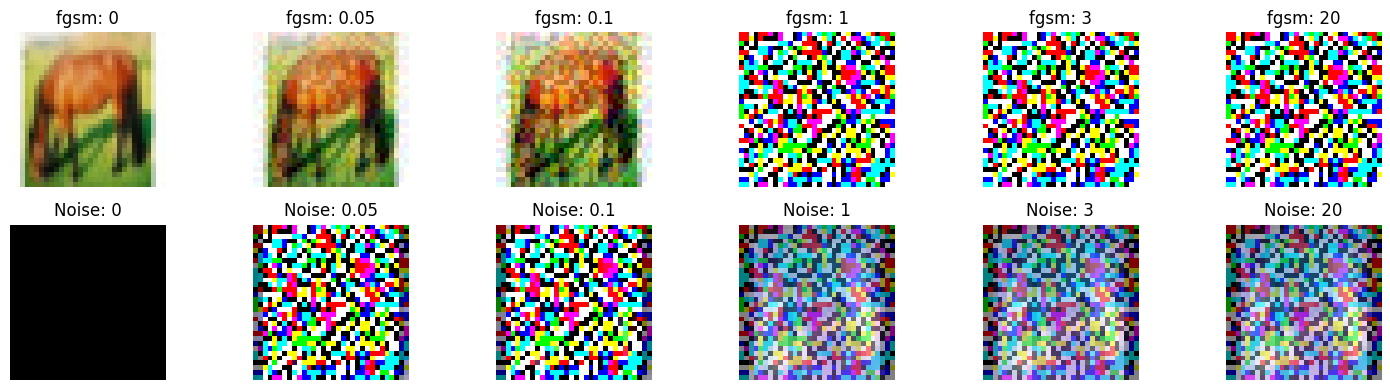

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.05, MSE: 0.002458140254020691, PSNR: 26.09393310546875, SSIM: 0.8725264668464661
epsilons: 0.1, MSE: 0.00957474671304226, PSNR: 20.18872833251953, SSIM: 0.6865047812461853
epsilons: 1, MSE: 0.00957474671304226, PSNR: 20.18872833251953, SSIM: 0.6865047812461853
epsilons: 3, MSE: 0.00957474671304226, PSNR: 20.18872833251953, SSIM: 0.6865047812461853
epsilons: 20, MSE: 0.00957474671304226, PSNR: 20.18872833251953, SSIM: 0.6865047812461853


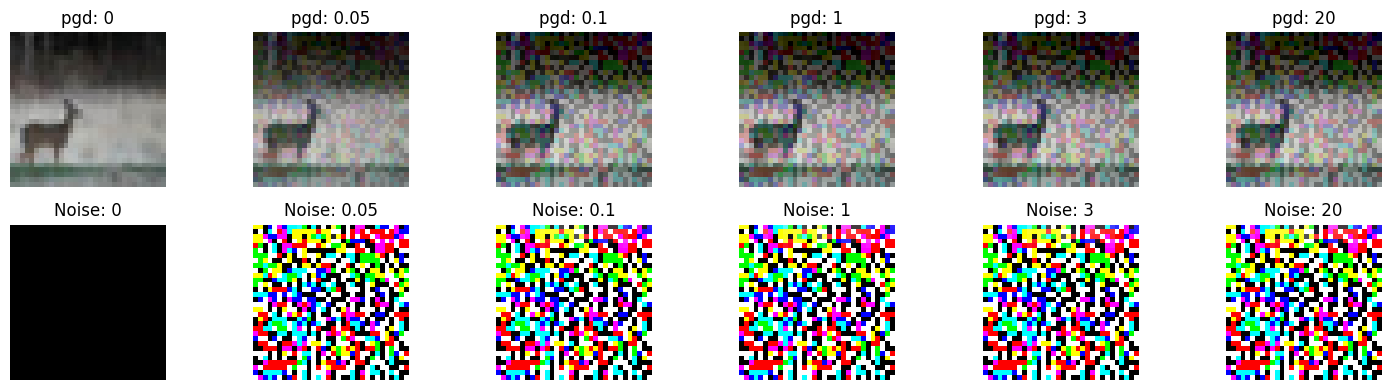

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.05, MSE: 8.12977930308989e-07, PSNR: 60.899208068847656, SSIM: 0.9998560547828674
epsilons: 0.1, MSE: 3.251660928071942e-06, PSNR: 54.87895202636719, SSIM: 0.999424397945404
epsilons: 1, MSE: 0.00032327778171747923, PSNR: 34.90424346923828, SSIM: 0.9542036056518555
epsilons: 3, MSE: 0.0028079692274332047, PSNR: 25.516075134277344, SSIM: 0.7845408320426941
epsilons: 20, MSE: 0.06380413472652435, PSNR: 11.951512336730957, SSIM: 0.21489179134368896


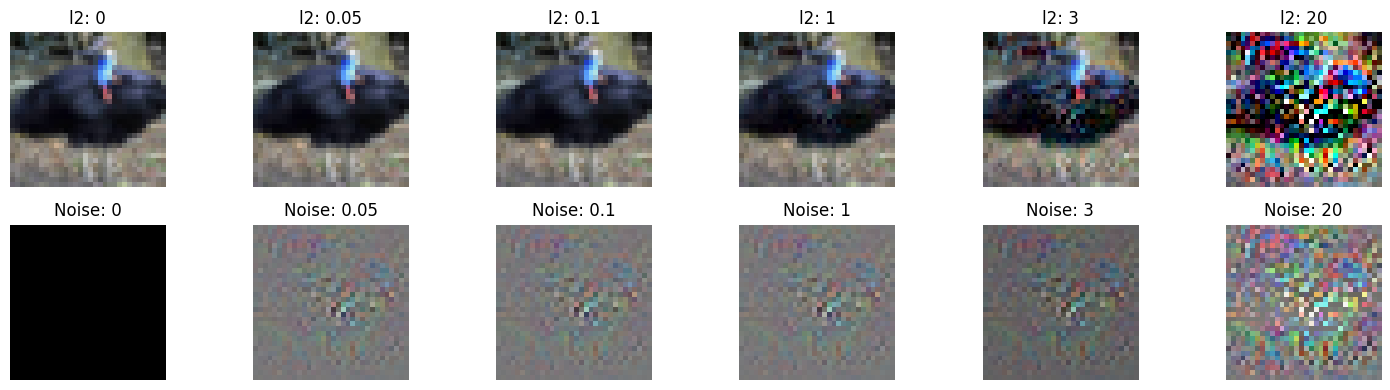

epsilons: 0, MSE: 3.905565336026484e-06, PSNR: 54.083160400390625, SSIM: 0.9994605183601379
epsilons: 0.05, MSE: 0.0024635393638163805, PSNR: 26.08440399169922, SSIM: 0.850848376750946
epsilons: 0.1, MSE: 0.009645073674619198, PSNR: 20.156944274902344, SSIM: 0.6548661589622498
epsilons: 1, MSE: 0.31655457615852356, PSNR: 4.995513439178467, SSIM: 0.00570698594674468
epsilons: 3, MSE: 0.31655457615852356, PSNR: 4.995513439178467, SSIM: 0.00570698594674468
epsilons: 20, MSE: 0.31655457615852356, PSNR: 4.995513439178467, SSIM: 0.00570698594674468


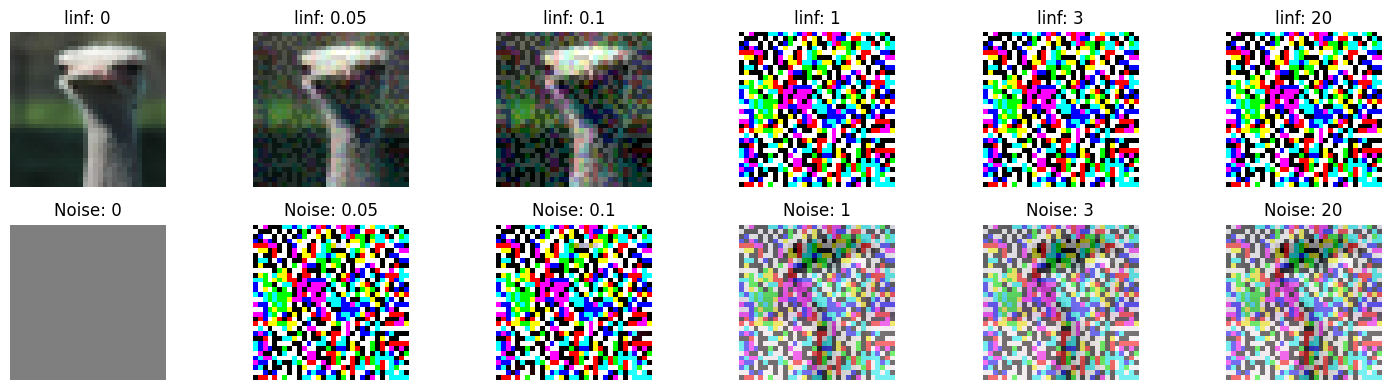

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.05, MSE: 2.71106642912855e-07, PSNR: 65.66859436035156, SSIM: 0.9999579787254333
epsilons: 0.1, MSE: 1.0844269127119333e-06, PSNR: 59.64799880981445, SSIM: 0.9998319149017334
epsilons: 1, MSE: 0.00010751414083642885, PSNR: 39.68534469604492, SSIM: 0.9857595562934875
epsilons: 3, MSE: 0.0009175401064567268, PSNR: 30.373748779296875, SSIM: 0.9210460186004639
epsilons: 20, MSE: 0.019675346091389656, PSNR: 17.06077766418457, SSIM: 0.541659414768219


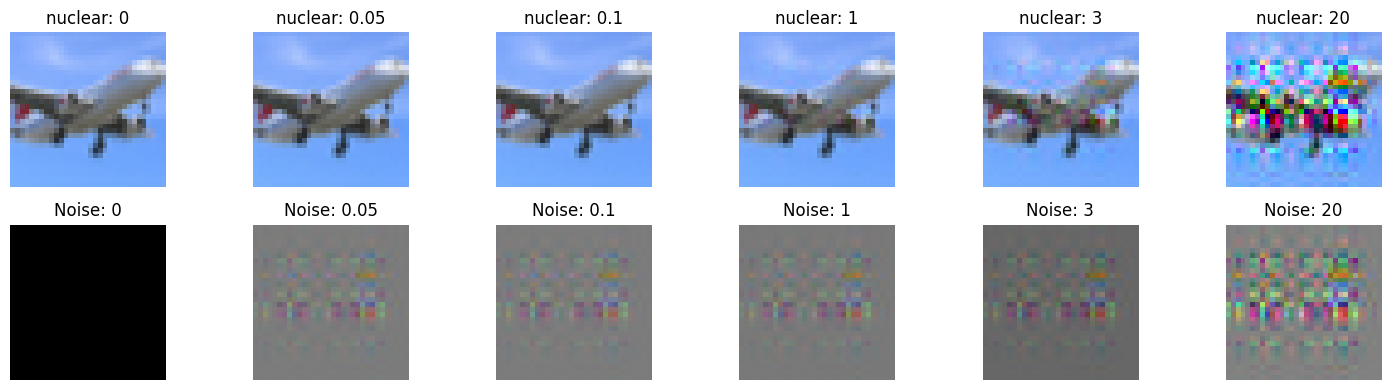

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.05, MSE: 5.948810333222809e-10, PSNR: 92.25569915771484, SSIM: 0.9999998211860657
epsilons: 0.1, MSE: 2.3795223569322843e-09, PSNR: 86.235107421875, SSIM: 0.9999997019767761
epsilons: 1, MSE: 2.3795227832579258e-07, PSNR: 66.235107421875, SSIM: 0.99997478723526
epsilons: 3, MSE: 2.141569666491705e-06, PSNR: 56.69267654418945, SSIM: 0.9997724890708923
epsilons: 20, MSE: 9.481707820668817e-05, PSNR: 40.23113250732422, SSIM: 0.9902032017707825


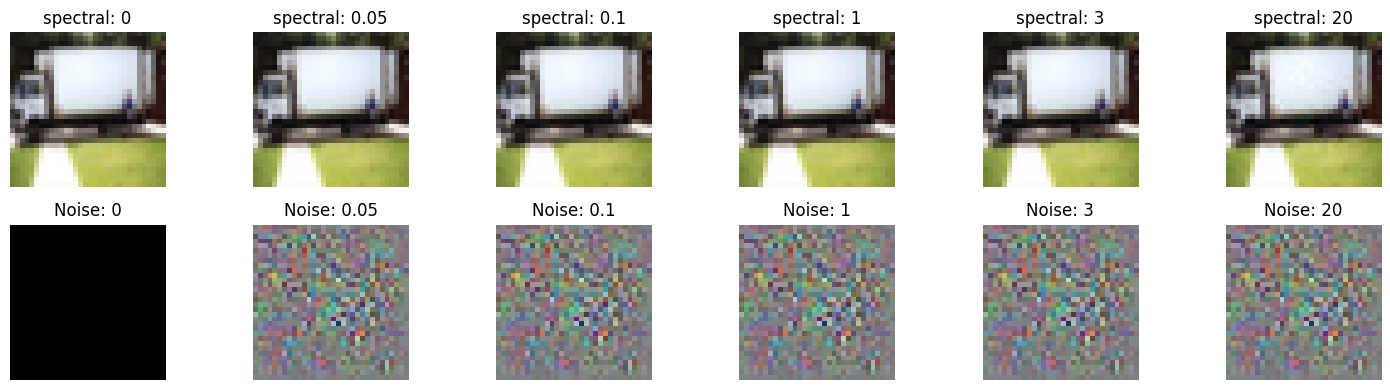

In [6]:
epsilons = [0, 0.05, 0.1, 1, 3, 20]
# attack_types = ['fgsm', 'pgd', 'l2', 'linf', 'nuclear']
attack_types = ['fgsm', 'pgd', 'l2', 'linf', 'nuclear', 'spectral']
alpha = 0.1
iters = 1

for attack_type in attack_types:
    fig, axes = plt.subplots(2, len(epsilons), figsize=(15, 4))
    for i, (images, labels) in enumerate(testloader):
        if i >= 1: break
        images, labels = images.to(device), labels.to(device)
        original_data_np = images.detach().cpu()

        for j, epsilon in enumerate(epsilons):
            # 应用攻击
            if attack_type == 'fgsm':
                perturbed_images = fgsm_attack(model, images, labels, epsilon)
            elif attack_type == 'pgd':
                perturbed_images = pgd_attack(model, images, labels, eps=epsilon, alpha=alpha, iters=iters)
            if attack_type == 'linf':
                perturbed_images = FW_Linf_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'l1':
                perturbed_images = FW_L1_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'l2':
                perturbed_images = FW_L2_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'nuclear':
                perturbed_images = FW_nuclear_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'spectral':
                perturbed_images = FW_spectral_attack(model, images, labels, radius=epsilon/16, eps=1e-10, step_size=1.0, iters=iters, device=device)
            
            perturbed_data_np = perturbed_images.detach().cpu()

            ax = axes[2*i, j]
            ax_perturbation = axes[i*2+1, j]
            imshow(perturbed_data_np, ax, f"{attack_type}: {epsilon}")
            
            noise = perturbed_data_np - original_data_np
            noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())  # 归一化噪音到0-1
            white_background = torch.ones_like(images).cpu()  # 创建一个白色背景
            noise_on_white = white_background * noise_normalized  # 将噪音加到白色背景上
            imshow(noise_on_white, ax_perturbation, f"Noise: {epsilon}")
            
            mse, psnr, ssim_val = calculate_metrics(original_data_np, perturbed_data_np)
            print(f'epsilons: {epsilon}, MSE: {mse}, PSNR: {psnr}, SSIM: {ssim_val}')

    plt.tight_layout()
    plt.show()